# Pricing vanilla call options and computing implied volatilities using neural networks



**EXECUTER CETTE CELLULE PUIS REDEMARRER L'ENVIRNEMENT ET REEXECUTER** 

In [10]:
# Basic imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# Updating scipy to use module QMC for Latin hypercube sampling
#!pip install scipy==1.7
from scipy.stats import qmc

# Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR, LinearLR, OneCycleLR, LambdaLR

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


# 1) Black Scholes pricing network: BS-ANN

### Closed-form formula

In [12]:
def bs_price_call(S, K, T, t, r, sigma):
  """
  Black-Scholes call option value price related to PDE (2). Returns option's price.
  S: spot price
  K: strike price
  T: time to maturity
  t: spot time
  r: interest rate
  sigma: volatility of underlying asset
  """

  # Boundary condition of Black-Sholes PDE (2)
  if T == t:
    return np.maximum(0, S - K)  
  # Solution of the PDE (2) on the open interval [t, T)
  else : 
    d1 = ( np.log(S / K) + (r + 0.5 * sigma ** 2) * (T-t) ) / (sigma * np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)
    value = S * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2) 
  
  return value

def bs_moneyness_call(moneyness, tau, r, sigma):
  """
  Same function as bs_price_call but in terms of moneyness. Returns V/K and 
  has S/K instead of two seperate paremeters S and K.
  moneyness: S/K
  Tau: time to maturity minus spot time
  r: interest rate
  sigma: volatility of underlying asset
  """

  d1 = ( np.log(moneyness) + (r + 0.5 * sigma ** 2) * (tau) ) / (sigma * np.sqrt(tau))
  d2 = d1 - sigma*np.sqrt(tau)
  value_moneyness = moneyness * norm.cdf(d1) - np.exp(-r * (tau)) * norm.cdf(d2) 
  
  return value_moneyness

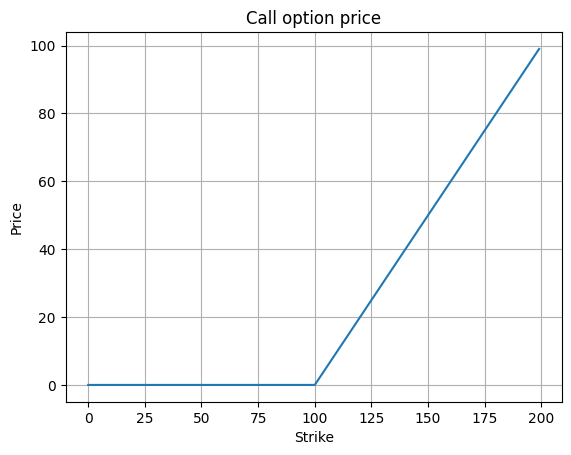

In [13]:
# Checking the call prices with respect to strikes
r, T, t, sigma, K, S = .02, 1, 1, .2, 100, np.arange(200)
plt.plot(S, bs_price_call(S, K, T, t, r, sigma))
plt.xlabel("Strike")
plt.ylabel("Price")
plt.title("Call option price" )
plt.grid()

### Data generation

In [14]:
def bs_LHS_data_generator(n = 10**6, l_bounds = [.4, .2, .02, .01], u_bounds = [1.6, 1.1, .1, 1]):
  """
  Generates samples of call prices using Latin hypercube sampling.
  Returns a torch float tensor of dimension (n,5) containig the inputs samples and the value of the call.
  The inputs are: Moneyness (S/K), time to maturity (tau), Risk free rate (r), Volatility (sigma).
  n: number of samples.
  l_bounds: lower bound for the inputs.  
  u_bounds: upper bound for the inputs.

  """
  sampler = qmc.LatinHypercube(d = 4)
  sample = sampler.random(n)
  sample = qmc.scale(sample, l_bounds, u_bounds)
  bs_prices = bs_moneyness_call(sample[:, 0], sample[:, 1], sample[:, 2], sample[:, 3]).reshape((-1, 1))
  bs_dataset = np.concatenate((sample, bs_prices),axis=1)

  print("------ INPUT ------")
  print("S/K.......... [{:.2f} {:.2f}]".format(min(bs_dataset[:,0]),max(bs_dataset[:,0])))
  print("Tau.......... [{:.2f} {:.2f}]".format(min(bs_dataset[:,1]),max(bs_dataset[:,1])))
  print("r............ [{:.2f} {:.2f}]".format(min(bs_dataset[:,2]),max(bs_dataset[:,2])))
  print("Sigma........ [{:.2f} {:.2f}]".format(min(bs_dataset[:,3]),max(bs_dataset[:,3])))
  print("------ OUTPUT ------")
  print("V/K.......... [{:.2f} {:.2f}]".format(min(bs_dataset[:,4]),max(bs_dataset[:,4])))


  return torch.FloatTensor(bs_dataset)

# Testing the function
bs_dataset = bs_LHS_data_generator()

------ INPUT ------
S/K.......... [0.40 1.60]
Tau.......... [0.20 1.10]
r............ [0.02 0.10]
Sigma........ [0.01 1.00]
------ OUTPUT ------
V/K.......... [0.00 0.90]


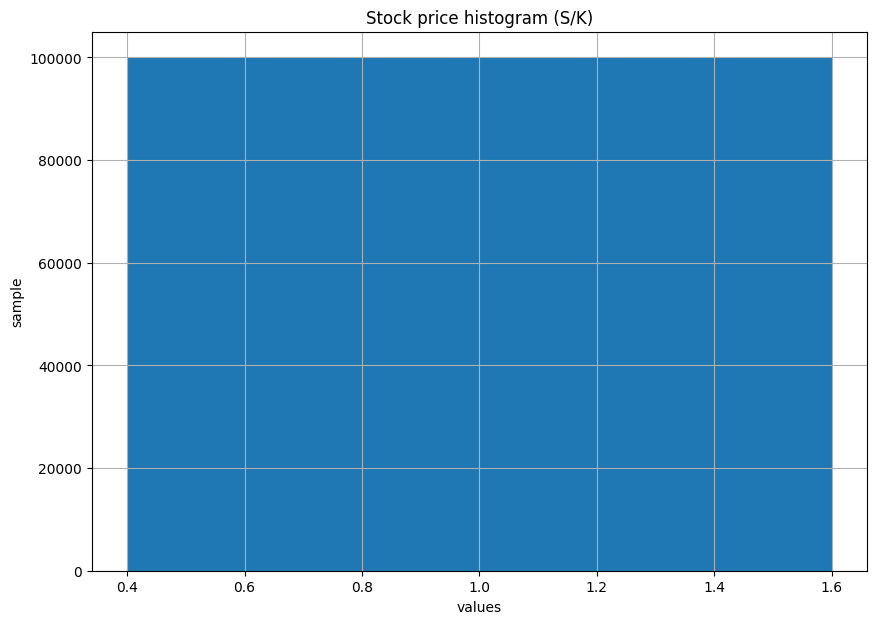

In [15]:
# Checking the LHS distribution of the input
plt.figure(figsize=(10,7))
h = plt.hist(bs_dataset[:,0], bins= 10)
plt.xlabel("values")
plt.ylabel("sample")
plt.title("Stock price histogram (S/K)" )
plt.grid()

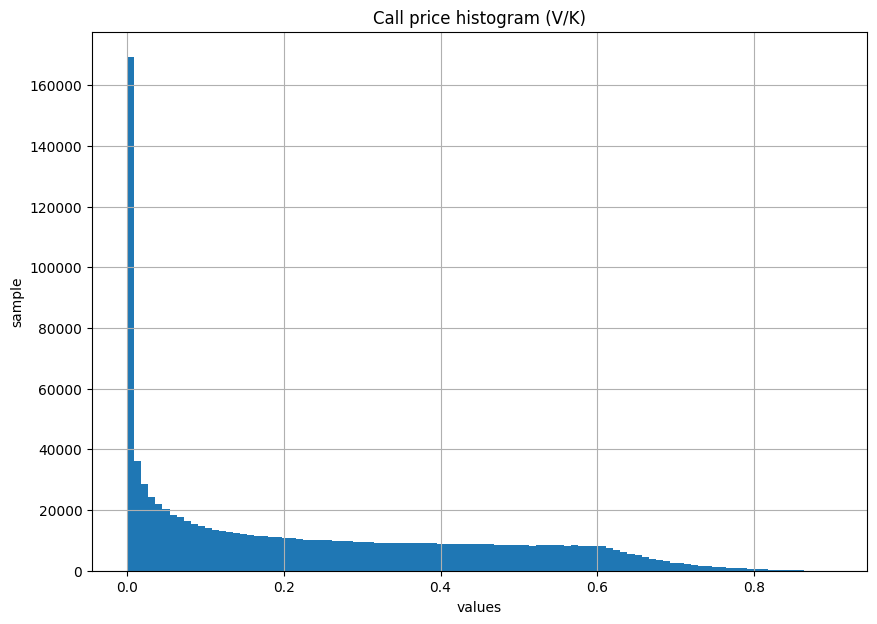

In [16]:
# Checking the output distribution (V/K).
plt.figure(figsize=(10,7))
h = plt.hist(bs_dataset[:,-1],bins=100)
plt.xlabel("values")
plt.ylabel("sample")
plt.title("Call price histogram (V/K)" )
plt.grid()

**Remark:** The majority of option prices are below 0.01

### Defining class BS-ANN

In [17]:
class BS_ANN(nn.Module):
  def __init__(self):
    """
    Initilize BS-ANN netwwork with four hidden layers. 
    Same architecture as the one used in table 2.
    Weight are initialized using Glorot_uniform also known as Xavier_uniform.
    """
    super(BS_ANN, self).__init__()
    # 4 layers
    self.fc1 = nn.Linear(4, 400)
    self.fc2 = nn.Linear(400, 400)
    self.fc3 = nn.Linear(400, 400)
    self.fc4 = nn.Linear(400, 400)
    self.fc5 = nn.Linear(400, 1)
    # initilizing the layer's weights
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    torch.nn.init.xavier_uniform_(self.fc3.weight)
    torch.nn.init.xavier_uniform_(self.fc4.weight)
    torch.nn.init.xavier_uniform_(self.fc5.weight)


  def forward(self, x):
    """
    Foward pass of the network. 
    Relu activations are used and a linear activation is used in the final layer.
    x: input torch tensor (CUDA or CPU)
    """
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = self.fc5(x)
    return x.flatten()

  def train_model(self, args, device, train_loader, optimizer, epoch):
    """
    Training over train_loader batches for one epoch.
    Returns average training loss.
    args: training parameters.
    device: CUDA or CPU.
    train_loader: train data loader.
    optimizer: gradient descent optmizer.
    epoch: current epoch.
    """
    # train mode
    self.train()
    train_loss = 0
    # loop over data loader
    for batch_idx, data in enumerate(train_loader):
      # extracting the inputs and target
      data, target = data[:,:-1].to(device), data[:,-1].to(device)
      # zeroing the gradients
      optimizer.zero_grad()
      # foward pass
      output = self(data)
      # computing the loss
      loss = F.mse_loss(output, target)
      train_loss += loss.item() *data.shape[0]
      # back propagation
      loss.backward()
      # updating the optimizer step
      optimizer.step()
      # printing batch information
      if batch_idx % args["log_interval"] == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tlog Loss: {:.6f}'.format(
            epoch, int(batch_idx / len(train_loader)*len(train_loader.dataset)), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.log(loss.item())))
        if args["dry_run"]:
          break
    train_loss /= len(train_loader.dataset)
    print('\nTrain set: Average log loss: {:.4f}\n'.format(np.log(train_loss))) 
    return train_loss


  def test_model(self, device, test_loader):
    """
    Testing over test_loader batches for one epoch. 
    Returns average test loss.
    device: CUDA or CPU.
    test_loader: test data loader.
    """
    # evaluation mode
    self.eval()
    test_loss = 0
    # freezing the gradients
    with torch.no_grad():
      # looping over the test laoder
      for data in test_loader:
        # extracting the inputs and target
        data, target = data[:,:-1].to(device), data[:,-1].to(device)
        # foward pass
        output = self(data)
        #computing the loss
        test_loss += F.mse_loss(output, target, reduction='sum').item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}\n'.format(np.log(test_loss))) 
    return test_loss

### Search of optimal Learning rate interval

In [23]:
# Setting the Training parameters
args =  {"batch_size": 1024,
         "test_batch_size": 1024,
         "epochs" : 200,
         "lr": 1,
         "gamma": 1,
         "no_cuda" : False,
         "run_dry": False,
         "seed": 0,
         "log_interval" : 10**6,
         "dry_run" : False,
         "save_model": False}

use_cuda = not args["no_cuda"] and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# torch.manual_seed(args["seed"])

# loading Train / Test Data
bs_dataset = bs_LHS_data_generator(n = 10**4)
train_size, test_size = int(bs_dataset.shape[0] * 0.9), int(bs_dataset.shape[0] * 0.1 )
train_dataset, test_dataset = torch.utils.data.random_split(bs_dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, args["batch_size"])
test_loader = torch.utils.data.DataLoader(test_dataset, args["test_batch_size"])


# Model training with Linear increase of the learning rate
model = BS_ANN().to(device)
# Adam optmizer
optimizer = optim.Adam(model.parameters(), lr = args["lr"])
# Linear increase of LR
lambda1 = lambda epoch: 10**(-9 + epoch*10/(args["epochs"] - 1) )
scheduler = LambdaLR(optimizer, lr_lambda = lambda1)


train_losses = []
test_losses = []
lrs = []
# Training loop over epochs
for epoch in range(1, args["epochs"] + 1):
  print("Current Learning rate {}".format(scheduler.get_last_lr()[0]))
  lrs.append(scheduler.get_last_lr())
  train_loss = model.train_model(args, device, train_loader, optimizer, epoch)
  test_loss = model.test_model(device, test_loader)
  scheduler.step()
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  if args["save_model"] & (epoch % 10**3) ==0:
    torch.save(model.state_dict(), "BS_ANN"+str(epoch)+".pt")
    


------ INPUT ------
S/K.......... [0.40 1.60]
Tau.......... [0.20 1.10]
r............ [0.02 0.10]
Sigma........ [0.01 1.00]
------ OUTPUT ------
V/K.......... [0.00 0.88]
Current Learning rate 1e-10
Train Epoch: 1 [0/9000 (0%)]	log Loss: -2.677069

Train set: Average log loss: -2.6054


Test set: Average loss: -2.5167

Current Learning rate 1.1226677735108158e-10
Train Epoch: 2 [0/9000 (0%)]	log Loss: -2.677069

Train set: Average log loss: -2.6054


Test set: Average loss: -2.5167

Current Learning rate 1.2603829296797273e-10
Train Epoch: 3 [0/9000 (0%)]	log Loss: -2.677069

Train set: Average log loss: -2.6054


Test set: Average loss: -2.5167

Current Learning rate 1.4149912974345787e-10
Train Epoch: 4 [0/9000 (0%)]	log Loss: -2.677070

Train set: Average log loss: -2.6054


Test set: Average loss: -2.5167

Current Learning rate 1.5885651294280527e-10
Train Epoch: 5 [0/9000 (0%)]	log Loss: -2.677070

Train set: Average log loss: -2.6054


Test set: Average loss: -2.5167

Current Lea

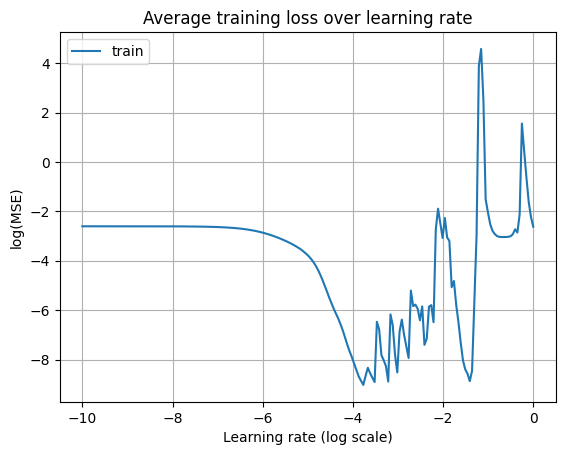

In [24]:
# Plotting the log MSE as a funtion of the learning rate
plt.plot(np.log10(lrs), np.log(train_losses), label = "train")
plt.xlabel("Learning rate (log scale)")
plt.ylabel("log(MSE)")
plt.title("Average training loss over learning rate" )
plt.grid()
plt.legend()

**Remark:** it seems like the best interval is from $10^{-4}$ to $10^{-6}$

Training WIDE 1.2428339981502956 VS in the article 8.04e-09


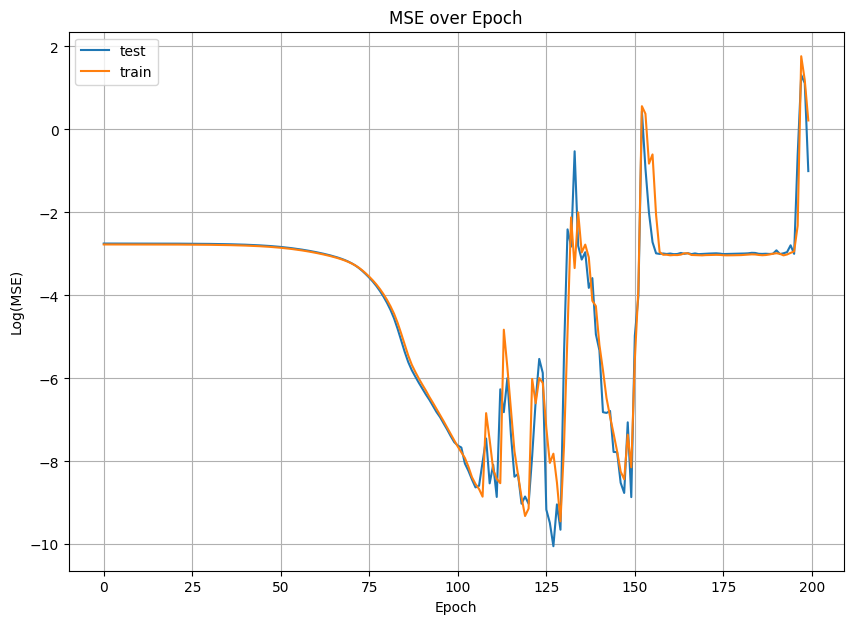

In [20]:
# ADDED CODE BOX
# Plotting the Log(MSE) with respect to the epoch
plt.figure(figsize=(10,7))
plt.plot( np.log(test_losses), label = "test")
plt.plot( np.log(train_losses), label = "train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Log(MSE)")
plt.title("MSE over Epoch" )
plt.grid()
print("Training WIDE {} VS in the article 8.04e-09".format(train_losses[-1]) )

### Training BS-ANN with DecayLR from $10^{-4}$ to $10^{-6}$ Wide dataset

In [11]:
# Training parameters
args =  {"batch_size": 1024,
         "test_batch_size": 4048,
         "epochs" : 3*10**3,
         "lr": 1e-4,
         "gamma": .1,
         "no_cuda" : False,
         "run_dry": False,
         "seed": 0,
         "log_interval" : 100,
         "dry_run" : False,
         "save_model": True}



use_cuda = not args["no_cuda"] and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# torch.manual_seed(args["seed"])


# Loading Train / Test Data
bs_dataset = bs_LHS_data_generator(n = 10**5)
train_size, test_size = int(bs_dataset.shape[0]*0.9), int(bs_dataset.shape[0]*0.1 ) # 10% SPLIT
train_dataset, test_dataset = torch.utils.data.random_split(bs_dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset,args["batch_size"])
test_loader = torch.utils.data.DataLoader(test_dataset, args["test_batch_size"])



print(device)
model = BS_ANN().to(device)
# Adam is found to be the best optimizer in the article
optimizer = optim.Adam(model.parameters(), lr = args["lr"]) 
# Deacreses the Learning rate by .1 every 1000 epoch
scheduler = StepLR(optimizer, step_size=10**3, gamma=args["gamma"]) 

train_losses = []
test_losses = []
# Training loop
for epoch in range(1, args["epochs"] + 1):
  train_loss = model.train_model(args, device, train_loader, optimizer, epoch)
  test_loss = model.test_model(device, test_loader)
  print("Current Learning rate {}".format(scheduler.get_last_lr()[0]))
  scheduler.step()
  train_losses.append(train_loss)
  test_losses.append(test_loss)
if args["save_model"] :
  torch.save(model.state_dict(), "BS_ANN.pt")
    

------ INPUT ------
S/K.......... [0.40 1.60]
Tau.......... [0.20 1.10]
r............ [0.02 0.10]
Sigma........ [0.01 1.00]
------ OUTPUT ------
V/K.......... [0.00 0.89]
cuda
Train Epoch: 1 [0/90000 (0%)]	log Loss: -1.878099

Train set: Average log loss: -3.9773


Test set: Average loss: -6.4762

Current Learning rate 0.0001
Train Epoch: 2 [0/90000 (0%)]	log Loss: -6.488426

Train set: Average log loss: -7.1410


Test set: Average loss: -7.7887

Current Learning rate 0.0001
Train Epoch: 3 [0/90000 (0%)]	log Loss: -7.836579

Train set: Average log loss: -8.2131


Test set: Average loss: -8.6201

Current Learning rate 0.0001
Train Epoch: 4 [0/90000 (0%)]	log Loss: -8.637086

Train set: Average log loss: -8.9441


Test set: Average loss: -9.3021

Current Learning rate 0.0001
Train Epoch: 5 [0/90000 (0%)]	log Loss: -9.280575

Train set: Average log loss: -9.6135


Test set: Average loss: -9.9635

Current Learning rate 0.0001
Train Epoch: 6 [0/90000 (0%)]	log Loss: -9.906272

Train set: Av

Training WIDE 2.3003252494251886e-08 VS in the article 8.04e-09


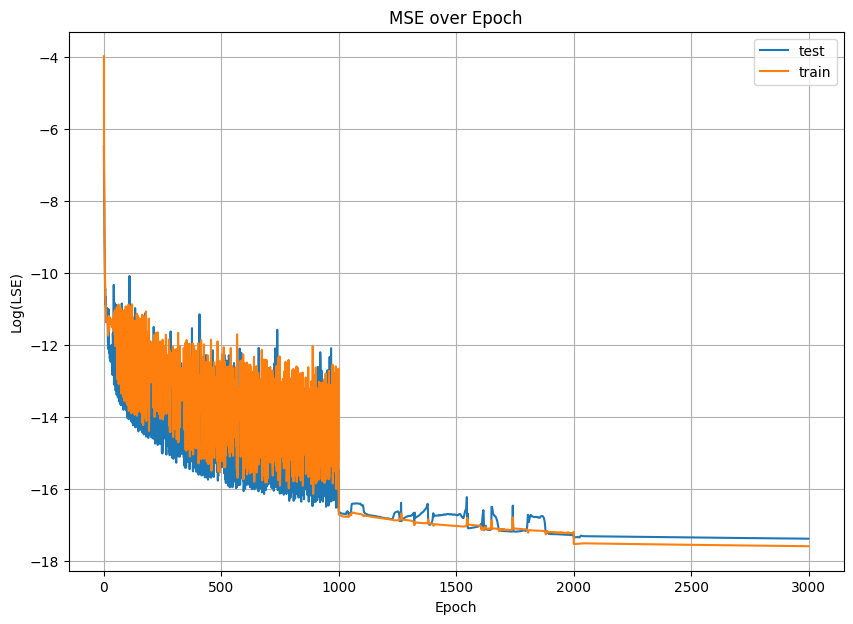

In [12]:
# Plotting the Log(MSE) with respect to the epoch
plt.figure(figsize=(10,7))
plt.plot( np.log(test_losses), label = "test")
plt.plot( np.log(train_losses), label = "train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Log(MSE)")
plt.title("MSE over Epoch" )
plt.grid()
print("Training WIDE {} VS in the article 8.04e-09".format(train_losses[-1]) )

In [8]:
# Loading model from saved parameters
loaded_BS_ANN = BS_ANN().to(device)
PATH = "ANN_weights/BS_ANN.pt"
loaded_BS_ANN.load_state_dict(torch.load(PATH))
loaded_BS_ANN.eval()


BS_ANN(
  (fc1): Linear(in_features=4, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=400, bias=True)
  (fc5): Linear(in_features=400, out_features=1, bias=True)
)

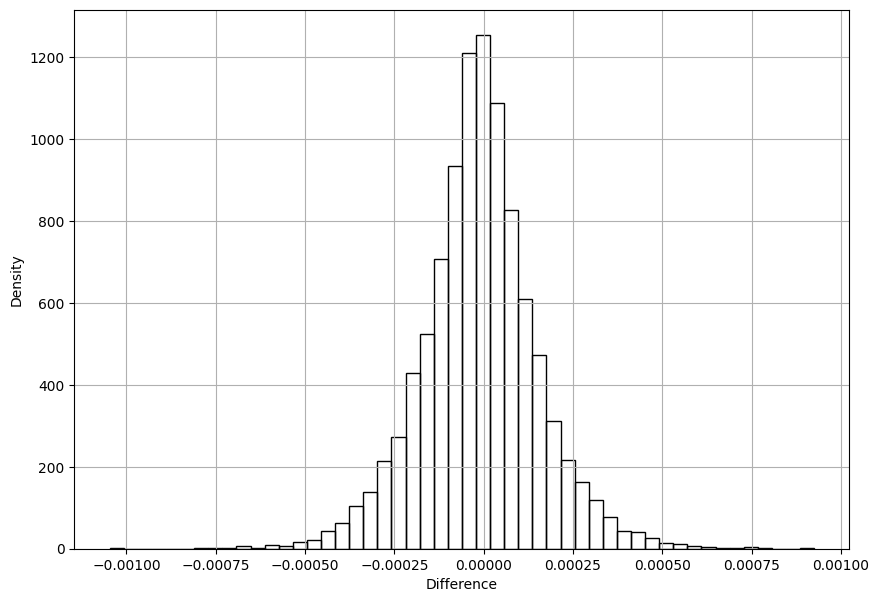

MAX  0.00092506036
MIN  -0.0010469928


In [14]:
# Plotting erros histogram
errors = []
with torch.no_grad():
  for data in test_loader:
    data, target = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_BS_ANN(data)
    errors.append((target-output).data.cpu().numpy())
  errors = np.concatenate(errors)
plt.figure(figsize=(10,7))
plt.hist(errors, 50, fill=False)
plt.grid()
plt.xlabel("Difference")
plt.ylabel("Density")
plt.show()
print("MAX ",errors.max())
print("MIN ",errors.min())


In [15]:
# Printing train and test MSE, MAE, MAPE and R2
outputs = []
targets = []
with torch.no_grad():
  for data in train_loader:
    data, target = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_BS_ANN(data)
    outputs.append((output).data.cpu().numpy())
    targets.append((target).data.cpu().numpy())
  outputs = np.concatenate(outputs)
  targets = np.concatenate(targets)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
print("-----------Train scores----------------")
print("MSE {:e}".format(mean_squared_error(outputs,targets)) )
print("MAE {:e}".format(mean_absolute_error(outputs,targets)) )
print("MAPE {:e}".format(mean_absolute_percentage_error(outputs,targets)) )
print("R2 {:e}".format(r2_score(outputs,targets)) )


outputs = []
targets = []
with torch.no_grad():
  for data in test_loader:
    data, target = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_BS_ANN(data)
    outputs.append((output).data.cpu().numpy())
    targets.append((target).data.cpu().numpy())
  outputs = np.concatenate(outputs)
  targets = np.concatenate(targets)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
print("-----------Test scores----------------")
print("MSE {:e}".format(mean_squared_error(outputs,targets)) )
print("MAE {:e}".format(mean_absolute_error(outputs,targets)) )
print("MAPE {:e}".format(mean_absolute_percentage_error(outputs,targets)) )
print("R2 {:e}".format(r2_score(outputs,targets)) )

-----------Train scores----------------
MSE 2.652397e-08
MAE 1.207284e-04
MAPE 1.947651e-01
R2 9.999994e-01
-----------Test scores----------------
MSE 2.647280e-08
MAE 1.212164e-04
MAPE 1.242439e-01
R2 9.999995e-01


In [16]:
np.sqrt(2.597518e-08)

0.00016116817303673826

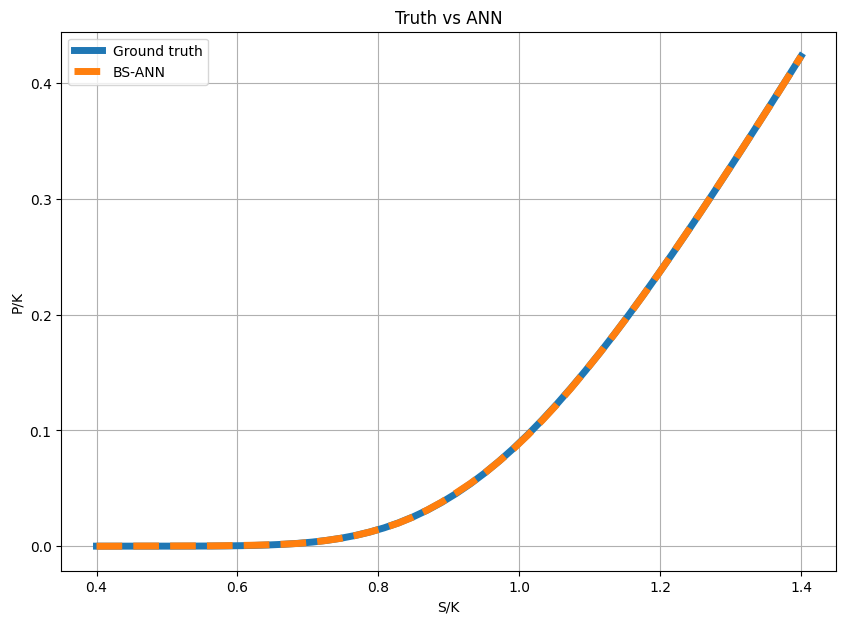

In [18]:
# Replace this with a matrix
moneyness = np.linspace(0.4,1.4)
tau, r, sigma = 1, .02, .2
prices = bs_moneyness_call(moneyness, tau, r, sigma)

plot_dateset = np.ones((50,4))
plot_dateset[:,0] = moneyness
plot_dateset[:,1] = plot_dateset[:,1]*tau
plot_dateset[:,2] = plot_dateset[:,2]*r
plot_dateset[:,3] = plot_dateset[:,3]*sigma


plt.figure(figsize=(10,7))
plt.plot(moneyness, prices, label="Ground truth", linewidth=5 )


plot_dateset = torch.from_numpy(plot_dateset).type(torch.FloatTensor).to(device)
output = loaded_BS_ANN(plot_dateset)
plt.plot(moneyness, output.data.cpu().numpy(), "--", label="BS-ANN", linewidth=5)

plt.legend()
plt.xlabel("S/K (moneyness)")
plt.ylabel("P/K")
plt.title("Truth vs ANN" )
plt.grid()

### Training BS-ANN with DecayLR from $10^{-4}$ to $10^{-6}$ Narrow dataset 

In [19]:
# Training parameters
args =  {"batch_size": 1024,
         "test_batch_size": 4048,
         "epochs" : 3*10**3,
         "lr": 1e-4,
         "gamma": .1,
         "no_cuda" : False,
         "run_dry": False,
         "seed": 0,
         "log_interval" : 100,
         "dry_run" : False,
         "save_model": True}



use_cuda = not args["no_cuda"] and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# torch.manual_seed(args["seed"])


# Loading Train / Test Data
l_bounds = [.5, .3, .03, .02]
u_bounds = [1.5, .95, .08, .9]
bs_dataset = bs_LHS_data_generator(n = 10**5,l_bounds=l_bounds, u_bounds=u_bounds)
train_size, test_size = int(bs_dataset.shape[0]*0.9), int(bs_dataset.shape[0]*0.1 ) # 10% SPLIT
train_dataset, test_dataset = torch.utils.data.random_split(bs_dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset,args["batch_size"])
test_loader = torch.utils.data.DataLoader(test_dataset, args["test_batch_size"])



print(device)
model = BS_ANN().to(device)
# Adam is found to be the best optimizer in the article
optimizer = optim.Adam(model.parameters(), lr=args["lr"]) 
# Deacreses the Learning rate by .1 every 1000 epoch
scheduler = StepLR(optimizer, step_size=10**3, gamma=args["gamma"]) 

train_losses = []
test_losses = []
# Training loop
for epoch in range(1, args["epochs"] + 1):
  train_loss = model.train_model(args, device, train_loader, optimizer, epoch)
  test_loss = model.test_model(device, test_loader)
  print("Current Learning rate {}".format(scheduler.get_last_lr()[0]))
  scheduler.step()
  train_losses.append(train_loss)
  test_losses.append(test_loss)
if args["save_model"] :
  torch.save(model.state_dict(), "BS_ANN_narrow.pt")
    

------ INPUT ------
S/K.......... [0.50 1.50]
Tau.......... [0.30 0.95]
r............ [0.03 0.08]
Sigma........ [0.02 0.90]
------ OUTPUT ------
V/K.......... [0.00 0.73]
cuda
Train Epoch: 1 [0/90000 (0%)]	log Loss: -2.623463

Train set: Average log loss: -4.5871


Test set: Average loss: -6.9200

Current Learning rate 0.0001
Train Epoch: 2 [0/90000 (0%)]	log Loss: -6.930228

Train set: Average log loss: -7.5880


Test set: Average loss: -8.3521

Current Learning rate 0.0001
Train Epoch: 3 [0/90000 (0%)]	log Loss: -8.407589

Train set: Average log loss: -8.8279


Test set: Average loss: -9.3110

Current Learning rate 0.0001
Train Epoch: 4 [0/90000 (0%)]	log Loss: -9.395084

Train set: Average log loss: -9.6382


Test set: Average loss: -9.8990

Current Learning rate 0.0001
Train Epoch: 5 [0/90000 (0%)]	log Loss: -9.922584

Train set: Average log loss: -10.1613


Test set: Average loss: -10.3838

Current Learning rate 0.0001
Train Epoch: 6 [0/90000 (0%)]	log Loss: -10.427864

Train set:

In [20]:
# Loading model from saved parameters
loaded_BS_ANN = BS_ANN().to(device)
PATH = "ANN_weights/BS_ANN_narrow.pt"
loaded_BS_ANN.load_state_dict(torch.load(PATH))
loaded_BS_ANN.eval()


BS_ANN(
  (fc1): Linear(in_features=4, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=400, bias=True)
  (fc5): Linear(in_features=400, out_features=1, bias=True)
)

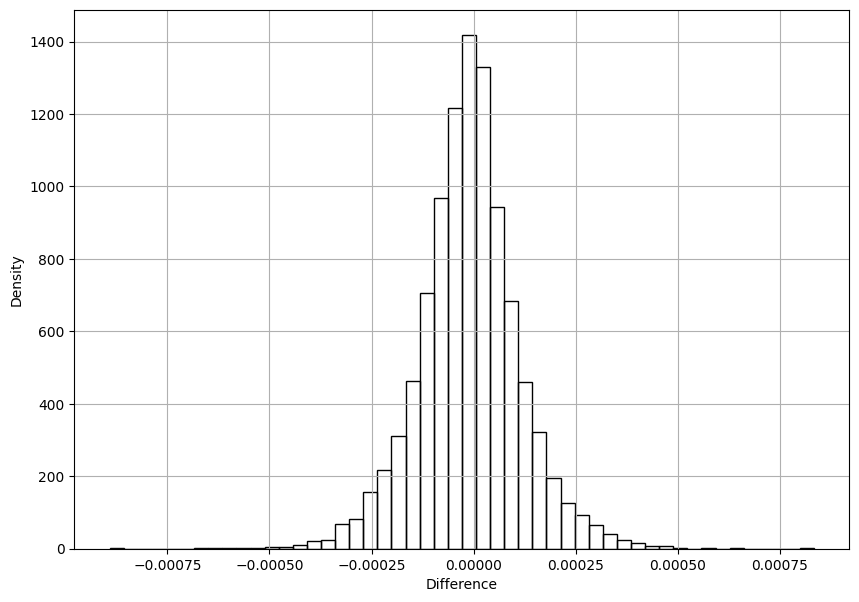

MAX  0.0008338839
MIN  -0.0008913651


In [21]:
# Plotting erros histogram
errors = []
with torch.no_grad():
  for data in test_loader:
    data, target = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_BS_ANN(data)
    errors.append((target-output).data.cpu().numpy())
  errors = np.concatenate(errors)
plt.figure(figsize=(10,7))
plt.hist(errors,50,fill=False)
plt.grid()
plt.xlabel("Difference")
plt.ylabel("Density")
plt.show()
print("MAX ",errors.max())
print("MIN ",errors.min())


In [22]:
# Printing train and test MSE, MAE, MAPE and R2
outputs = []
targets = []
with torch.no_grad():
  for data in train_loader:
    data, target = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_BS_ANN(data)
    outputs.append((output).data.cpu().numpy())
    targets.append((target).data.cpu().numpy())
  outputs = np.concatenate(outputs)
  targets = np.concatenate(targets)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
print("-----------Train scores----------------")
print("MSE {:e}".format(mean_squared_error(outputs,targets)) )
print("MAE {:e}".format(mean_absolute_error(outputs,targets)) )
print("MAPE {:e}".format(mean_absolute_percentage_error(outputs,targets)) )
print("R2 {:e}".format(r2_score(outputs,targets)) )


outputs = []
targets = []
with torch.no_grad():
  for data in test_loader:
    data, target = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_BS_ANN(data)
    outputs.append((output).data.cpu().numpy())
    targets.append((target).data.cpu().numpy())
  outputs = np.concatenate(outputs)
  targets = np.concatenate(targets)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
print("-----------Test scores----------------")
print("MSE {:e}".format(mean_squared_error(outputs,targets)) )
print("MAE {:e}".format(mean_absolute_error(outputs,targets)) )
print("MAPE {:e}".format(mean_absolute_percentage_error(outputs,targets)) )
print("R2 {:e}".format(r2_score(outputs,targets)) )

-----------Train scores----------------
MSE 1.578677e-08
MAE 9.406319e-05
MAPE 9.084946e-02
R2 9.999995e-01
-----------Test scores----------------
MSE 1.529350e-08
MAE 9.230250e-05
MAPE 9.723768e-02
R2 9.999995e-01


In [23]:
np.sqrt(1.554532e-08)

0.00012468087263088913

# 2) Implied volatility network: IV-ANN

### Defining class IV-ANN 

In [25]:
class IV_ANN(BS_ANN):
    # The authors of the paper seem to use
    # the same architecture both for BS-ANN and the IV-ANN
    # thus the class inherets from BS_ANN
  pass

### Data Generation with log transformation

Log transformation 

$\tilde{V}=V_{t}-\max \left(S_{t}-K e^{-r \tau}, 0\right)$

$\left\{\log (\tilde{V} / K), S_{0} / K, r, \tau\right\}$

In [26]:
def IV_LHS_data_generator(n = 10**6, l_bounds = [.5, .05, .0, .05], u_bounds = [1.4, 1, .1, 1], log_scale = True):
  """
  Generates samples of call prices using Latin hypercube sampling.
  Returns a torch float tensor of dimension (n,5) containig the inputs samples and the volatility as the target.
  Performs a log transormation of V/K.
  The inputs are: Moneyness (S/K), time to maturity (tau), Risk free rate (r), Volatility (sigma).
  n: number of samples.
  l_bounds: lower bound for the inputs.  
  u_bounds: upper bound for the inputs.
  log_scale: performs log transformation if True.

  """
  sampler = qmc.LatinHypercube(d=4)
  sample = sampler.random(n)
  sample = qmc.scale(sample, l_bounds, u_bounds)
  bs_prices = bs_moneyness_call(sample[:,0], sample[:,1], sample[:,2], sample[:,3]).reshape((-1,1))


  bs_dataset = np.concatenate((sample[:,:-1], bs_prices, sample[:,3].reshape((n,1))),axis=1)
  # log transformation as in section 4.3
  if log_scale : 
    bs_dataset[:,3] = bs_dataset[:,3] - np.maximum(bs_dataset[:,0]-np.exp(-bs_dataset[:,1]*bs_dataset[:,2]),0)
    indecies = np.argwhere(bs_dataset[:,3]< 1e-7)
    bs_dataset = np.delete(bs_dataset, indecies,0)
    bs_dataset[:,3] = np.log(bs_dataset[:,3])

  print("------ INPUT ------")
  print("S/K.......... [{:.2f} {:.2f}]".format(min(bs_dataset[:,0]),max(bs_dataset[:,0])))
  print("Tau.......... [{:.2f} {:.2f}]".format(min(bs_dataset[:,1]),max(bs_dataset[:,1])))
  print("r............ [{:.2f} {:.2f}]".format(min(bs_dataset[:,2]),max(bs_dataset[:,2])))
  if log_scale : 
    print("log(V/K)..... [{:.2f} {:.2f}]".format(min(bs_dataset[:,3]),max(bs_dataset[:,3])))
  else : 
    print("V/K.......... [{:.2f} {:.2f}]".format(min(bs_dataset[:,3]),max(bs_dataset[:,3])))
  print("------ OUTPUT ------")
  print("Sigma........ [{:.2f} {:.2f}]".format(min(bs_dataset[:,4]),max(bs_dataset[:,4])))
  return torch.FloatTensor(bs_dataset)

bs_dataset = IV_LHS_data_generator(log_scale = True)

------ INPUT ------
S/K.......... [0.50 1.40]
Tau.......... [0.05 1.00]
r............ [0.00 0.10]
log(V/K)..... [-16.12 -0.99]
------ OUTPUT ------
Sigma........ [0.05 1.00]


### Training IV-ANN with log transofmation

In [27]:
# Training parameters
args =  {"batch_size": 1024,
         "test_batch_size": 4048,
         "epochs" : 3*10**3,
         "lr": 1e-4,
         "gamma": .1,
         "no_cuda" : False,
         "run_dry": False,
         "seed": 0,
         "log_interval" : 100,
         "dry_run" : False,
         "save_model": True}



use_cuda = not args["no_cuda"] and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# torch.manual_seed(args["seed"])

# Loading Train / Test Data
bs_dataset = IV_LHS_data_generator(n = 10**5, log_scale = True)
train_size, test_size = int(bs_dataset.shape[0]*0.9), int(bs_dataset.shape[0]*0.1 ) # 10% SPLIT
train_dataset, test_dataset = torch.utils.data.random_split(bs_dataset, [train_size, bs_dataset.shape[0]-train_size])

train_loader = torch.utils.data.DataLoader(train_dataset,args["batch_size"])
test_loader = torch.utils.data.DataLoader(test_dataset, args["test_batch_size"])


# Model training
print(device)
model = IV_ANN().to(device)
optimizer = optim.Adam(model.parameters(), lr=args["lr"]) # Adam is found to be the best optimizer in the article
scheduler = StepLR(optimizer, step_size=10**3, gamma=args["gamma"]) # Deacreses the Learning rate by .1 every 1000 epoch

train_losses = []
test_losses = []
for epoch in range(1, args["epochs"] + 1):
  train_loss = model.train_model(args, device, train_loader, optimizer, epoch)
  test_loss = model.test_model(device, test_loader)
  print("Current Learning rate {}".format(scheduler.get_last_lr()[0]))
  scheduler.step()
  train_losses.append(train_loss)
  test_losses.append(test_loss)
if args["save_model"] :
  torch.save(model.state_dict(), "IV_SCALED_ANN.pt")
    

------ INPUT ------
S/K.......... [0.50 1.40]
Tau.......... [0.05 1.00]
r............ [0.00 0.10]
log(V/K)..... [-16.12 -0.99]
------ OUTPUT ------
Sigma........ [0.05 1.00]
cuda
Train Epoch: 1 [0/85187 (0%)]	log Loss: -0.671939

Train set: Average log loss: -2.8045


Test set: Average loss: -3.6490

Current Learning rate 0.0001
Train Epoch: 2 [0/85187 (0%)]	log Loss: -3.637234

Train set: Average log loss: -3.8461


Test set: Average loss: -4.0413

Current Learning rate 0.0001
Train Epoch: 3 [0/85187 (0%)]	log Loss: -4.062339

Train set: Average log loss: -4.2294


Test set: Average loss: -4.4881

Current Learning rate 0.0001
Train Epoch: 4 [0/85187 (0%)]	log Loss: -4.476239

Train set: Average log loss: -4.8251


Test set: Average loss: -5.2713

Current Learning rate 0.0001
Train Epoch: 5 [0/85187 (0%)]	log Loss: -5.229585

Train set: Average log loss: -5.6174


Test set: Average loss: -5.9795

Current Learning rate 0.0001
Train Epoch: 6 [0/85187 (0%)]	log Loss: -5.890696

Train set:

In [29]:
# Loading model from saved weights
device = torch.device("cuda")
loaded_IV_ANN = IV_ANN().to(device)
PATH = "ANN_weights/IV_SCALED_ANN.pt"
loaded_IV_ANN.load_state_dict(torch.load(PATH))
loaded_IV_ANN.eval()


IV_ANN(
  (fc1): Linear(in_features=4, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=400, bias=True)
  (fc5): Linear(in_features=400, out_features=1, bias=True)
)

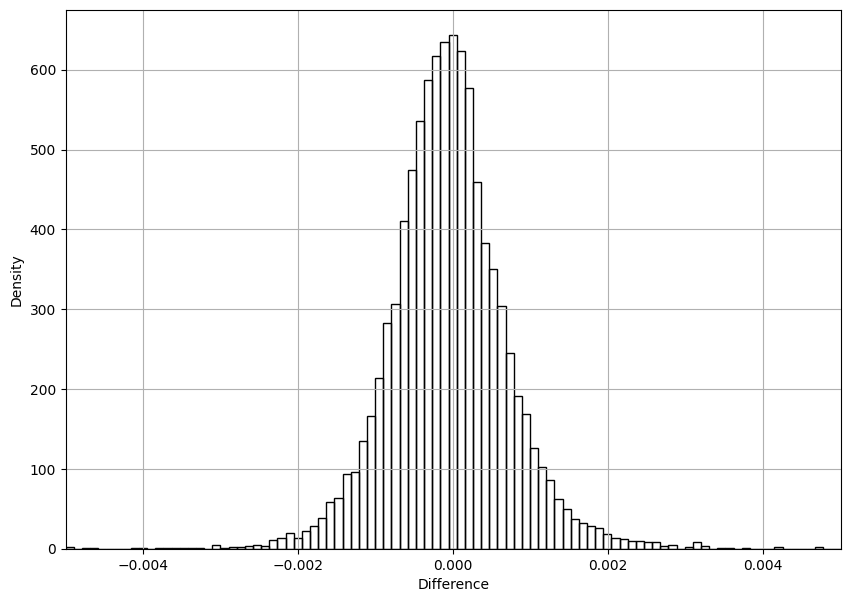

MAX  0.005511403
MIN  -0.0050005317


In [30]:
# Plotting erros histogram
errors = []
with torch.no_grad():
  for data in test_loader:
    data, target = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_IV_ANN(data)
    errors.append((target-output).data.cpu().numpy())
  errors = np.concatenate(errors)
plt.figure(figsize=(10,7))
plt.hist(errors,100,fill=False)
plt.grid()
plt.xlabel("Difference")
plt.ylabel("Density")
plt.xlim([-0.005, 0.005])
plt.show()
print("MAX ",errors.max())
print("MIN ",errors.min())


In [31]:
# Printing train and test MSE, MAE, MAPE and R2
outputs = []
targets = []
with torch.no_grad():
  for data in train_loader:
    data, target = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_IV_ANN(data)
    outputs.append((output).data.cpu().numpy())
    targets.append((target).data.cpu().numpy())
  outputs = np.concatenate(outputs)
  targets = np.concatenate(targets)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
print("-----------Train scores----------------")
print("MSE {:e}".format(mean_squared_error(outputs,targets)) )
print("MAE {:e}".format(mean_absolute_error(outputs,targets)) )
print("MAPE {:e}".format(mean_absolute_percentage_error(outputs,targets)) )
print("R2 {:e}".format(r2_score(outputs,targets)) )


outputs = []
targets = []
with torch.no_grad():
  for data in test_loader:
    data, target = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_IV_ANN(data)
    outputs.append((output).data.cpu().numpy())
    targets.append((target).data.cpu().numpy())
  outputs = np.concatenate(outputs)
  targets = np.concatenate(targets)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
print("-----------Test scores----------------")
print("MSE {:e}".format(mean_squared_error(outputs,targets)) )
print("MAE {:e}".format(mean_absolute_error(outputs,targets)) )
print("MAPE {:e}".format(mean_absolute_percentage_error(outputs,targets)) )
print("R2 {:e}".format(r2_score(outputs,targets)) )

-----------Train scores----------------
MSE 6.137644e-07
MAE 5.638418e-04
MAPE 1.528163e-03
R2 9.999912e-01
-----------Test scores----------------
MSE 5.863549e-07
MAE 5.648760e-04
MAPE 1.545854e-03
R2 9.999915e-01


### Training IV-ANN without log transofmation

In [32]:
# Training parameters
args =  {"batch_size": 1024,
         "test_batch_size": 4048,
         "epochs" : 3*10**3,
         "lr": 1e-4,
         "gamma": .1,
         "no_cuda" : False,
         "run_dry": False,
         "seed": 0,
         "log_interval" : 100,
         "dry_run" : False,
         "save_model": True}



use_cuda = not args["no_cuda"] and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# torch.manual_seed(args["seed"])


# Train / Test Data
bs_dataset = IV_LHS_data_generator(n = 10**5, log_scale = False)
train_size, test_size = int(bs_dataset.shape[0]*0.9), int(bs_dataset.shape[0]*0.1 ) # 10% SPLIT
train_dataset, test_dataset = torch.utils.data.random_split(bs_dataset, [train_size, bs_dataset.shape[0]-train_size])

train_loader = torch.utils.data.DataLoader(train_dataset,args["batch_size"])
test_loader = torch.utils.data.DataLoader(test_dataset, args["test_batch_size"])


# Model training
print(device)
model = BS_ANN().to(device)
optimizer = optim.Adam(model.parameters(), lr=args["lr"]) # Adam is found to be the best optimizer in the article
scheduler = StepLR(optimizer, step_size=10**3, gamma=args["gamma"]) # Deacreses the Learning rate by .1 every 1000 epoch

train_losses = []
test_losses = []
for epoch in range(1, args["epochs"] + 1):
  train_loss = model.train_model(args, device, train_loader, optimizer, epoch)
  test_loss = model.test_model(device, test_loader)
  print("Current Learning rate {}".format(scheduler.get_last_lr()[0]))
  scheduler.step()
  train_losses.append(train_loss)
  test_losses.append(test_loss)
if args["save_model"] :
  torch.save(model.state_dict(), "IV_UNSCALED_ANN.pt")
    

------ INPUT ------
S/K.......... [0.50 1.40]
Tau.......... [0.05 1.00]
r............ [0.00 0.10]
V/K.......... [0.00 0.69]
------ OUTPUT ------
Sigma........ [0.05 1.00]
cuda
Train Epoch: 1 [0/90000 (0%)]	log Loss: -0.959341

Train set: Average log loss: -2.4540


Test set: Average loss: -2.6480

Current Learning rate 0.0001
Train Epoch: 2 [0/90000 (0%)]	log Loss: -2.619602

Train set: Average log loss: -2.7389


Test set: Average loss: -2.9221

Current Learning rate 0.0001
Train Epoch: 3 [0/90000 (0%)]	log Loss: -2.905974

Train set: Average log loss: -3.2516


Test set: Average loss: -3.6121

Current Learning rate 0.0001
Train Epoch: 4 [0/90000 (0%)]	log Loss: -3.637082

Train set: Average log loss: -3.8467


Test set: Average loss: -4.0643

Current Learning rate 0.0001
Train Epoch: 5 [0/90000 (0%)]	log Loss: -4.068975

Train set: Average log loss: -4.2036


Test set: Average loss: -4.3170

Current Learning rate 0.0001
Train Epoch: 6 [0/90000 (0%)]	log Loss: -4.306699

Train set: Av

In [33]:
# Loading model
device = torch.device("cuda")
loaded_IV_ANN_UN = IV_ANN().to(device)
PATH = "ANN_weights/IV_UNSCALED_ANN.pt"
loaded_IV_ANN_UN.load_state_dict(torch.load(PATH))
loaded_IV_ANN_UN.eval()


IV_ANN(
  (fc1): Linear(in_features=4, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=400, bias=True)
  (fc5): Linear(in_features=400, out_features=1, bias=True)
)

MAX  0.23030132
MIN  -0.44819307


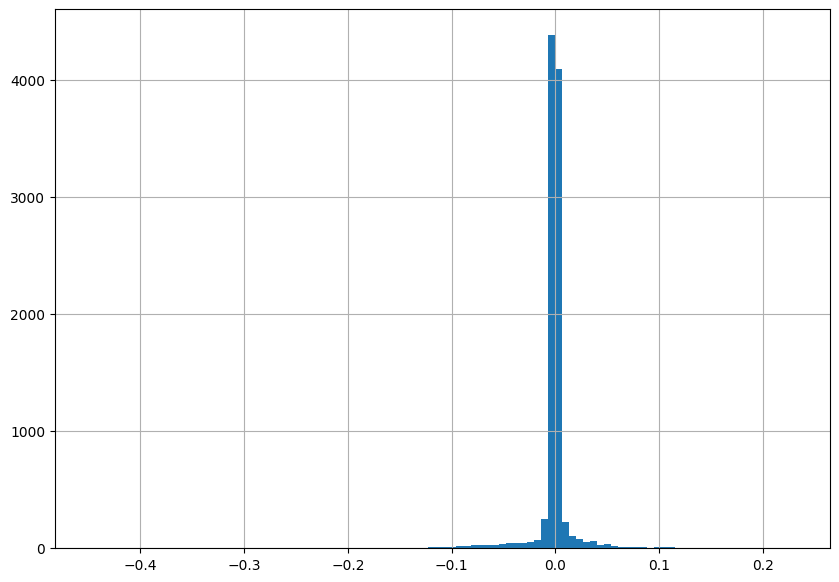

In [34]:
# Plotting erros histogram
errors = []
with torch.no_grad():
  for data in test_loader:
    data, target = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_IV_ANN_UN(data)
    errors.append((target-output).data.cpu().numpy())
  errors = np.concatenate(errors)
plt.figure(figsize=(10,7))
h = plt.hist(errors,100)
plt.grid()
print("MAX ",errors.max())
print("MIN ",errors.min())


In [35]:
# Printing train and test MSE, MAE, MAPE and R2
outputs = []
targets = []
with torch.no_grad():
  for data in train_loader:
    data, target = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_IV_ANN_UN(data)
    outputs.append((output).data.cpu().numpy())
    targets.append((target).data.cpu().numpy())
  outputs = np.concatenate(outputs)
  targets = np.concatenate(targets)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
print("-----------Train scores----------------")
print("MSE {:e}".format(mean_squared_error(outputs,targets)) )
print("MAE {:e}".format(mean_absolute_error(outputs,targets)) )
print("MAPE {:e}".format(mean_absolute_percentage_error(outputs,targets)) )
print("R2 {:e}".format(r2_score(outputs,targets)) )


outputs = []
targets = []
with torch.no_grad():
  for data in test_loader:
    data, target = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_IV_ANN_UN(data)
    outputs.append((output).data.cpu().numpy())
    targets.append((target).data.cpu().numpy())
  outputs = np.concatenate(outputs)
  targets = np.concatenate(targets)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
print("-----------Test scores----------------")
print("MSE {:e}".format(mean_squared_error(outputs,targets)) )
print("MAE {:e}".format(mean_absolute_error(outputs,targets)) )
print("MAPE {:e}".format(mean_absolute_percentage_error(outputs,targets)) )
print("R2 {:e}".format(r2_score(outputs,targets)) )

-----------Train scores----------------
MSE 6.599748e-04
MAE 8.277198e-03
MAPE 3.761932e-02
R2 9.910348e-01
-----------Test scores----------------
MSE 6.838114e-04
MAE 8.216325e-03
MAPE 3.740349e-02
R2 9.906515e-01


# 3) COS Method

#### Vanilla call coefficients

$\begin{aligned} \chi_{k}(c, d):=& \frac{1}{1+\left(\frac{k \pi}{b-a}\right)^{2}}\left[\cos \left(k \pi \frac{d-a}{b-a}\right) e^{d}-\cos \left(k \pi \frac{c-a}{b-a}\right) e^{c}\right.\\ &\left.+\frac{k \pi}{b-a} \sin \left(k \pi \frac{d-a}{b-a}\right) e^{d}-\frac{k \pi}{b-a} \sin \left(k \pi \frac{c-a}{b-a}\right) e^{c}\right] \end{aligned}$

$\psi_{k}(c, d):= \begin{cases}{\left[\sin \left(k \pi \frac{d-a}{b-a}\right)-\sin \left(k \pi \frac{c-a}{b-a}\right)\right] \frac{b-a}{k \pi},} & k \neq 0, \\ (d-c), & k=0 .\end{cases}$

$V_{k}^{\text {call }}=\frac{2}{b-a} K\left(\chi_{k}(0, b)-\psi_{k}(0, b)\right)$

In [36]:
def call_cosine_coef(a, b, c, d, K, N):
  """
  Coefficient V_k for plain vanilla options. 
  Section 3.1, equations (22) and (23).
  a, b, c, d: truncation range parameters.
  K: Strike.
  N: summing lenght.
  Returns V_k coefficient for call option.
  """
  k = np.arange(N).reshape(1,-1)
  bma    = b - a
  uu     = k * np.pi / bma
  chi_k = 1 / (1 + uu **2 ) * \
  ( np.cos(uu * ( d - a))* np.exp(d) - np.cos(uu * (c - a))* np.exp(c) + uu * np.sin(uu * (d - a)) * np.exp(d)- uu * np.sin(uu*(c-a))* np.exp(c) )
  psi_k = uu
  psi_k[:,1:] = 1 / uu[:,1:] * ( np.sin(uu[:,1:] * ( d - a )) - np.sin( uu[:,1:] * ( c - a) ) )
  psi_k[:,0] = (d - c).flatten() #d - c 
  return 2/bma*K*(chi_k-psi_k)

In [37]:
def call_cosine_coef_moy(a, b, c, d, N):
  """
  Moyeness version.
  Coefficient V_k for plain vanilla options. 
  Section 3.1, equations (22) and (23).
  a, b, c, d: truncation range parameters.
  N: summing lenght.
  Returns V_k coefficient for call option devided by K.
  """
  k = np.arange(N).reshape(1,-1)
  bma    = b - a
  uu     = k * np.pi / bma
  chi_k = 1 / (1 + uu **2 ) * \
  ( np.cos(uu * ( d - a))* np.exp(d) - np.cos(uu * (c - a))* np.exp(c) + uu * np.sin(uu * (d - a)) * np.exp(d)- uu * np.sin(uu*(c-a))* np.exp(c) )
  psi_k = uu
  psi_k[:,1:] = 1 / uu[:,1:] * ( np.sin(uu[:,1:] * ( d - a )) - np.sin( uu[:,1:] * ( c - a) ) )
  psi_k[:,0] = (d - c).flatten() #d - c 
  return 2/bma*(chi_k-psi_k)

#### Charateristic function for Heston model

$\begin{aligned} \varphi_{h e s}\left(\omega ; u_{0}\right)=& \exp \left(i \omega \mu \Delta t+\frac{u_{0}}{\eta^{2}}\left(\frac{1-e^{-D \Delta t}}{1-G e^{-D \Delta t}}\right)(\lambda-i \rho \eta \omega-D)\right) \\ & \cdot \exp \left(\frac{\lambda \bar{u}}{\eta^{2}}\left(\Delta t(\lambda-i \rho \eta \omega-D)-2 \log \left(\frac{1-G e^{-D \Delta t}}{1-G}\right)\right)\right) \end{aligned}$

$D=\sqrt{(\lambda-i \rho \eta \omega)^{2}+\left(\omega^{2}+i \omega\right) \eta^{2}} \quad$ and $\quad G=\frac{\lambda-i \rho \eta \omega-D}{\lambda-i \rho \eta \omega+D} $

In [38]:
def phi_Heston(a ,b ,N ,r, tau, kappa, gamma, vbar, v0, rho):
  """
  Characteristic function of the log-asset price following the Heston model.
  Section 3.3, equation (33).
  a, b: truncation range parameters.
  N: summing lenght.
  r: risk free rate.
  tau: time to maturity.
  kappa: reversion speed .
  gamma: Vol of vol.
  vbar: Long average variance.
  v0: Initial variance.
  rho: Correlation.
  Returns Charateristic function vector.
  """
  k = np.arange(N).reshape(1,-1)
  u = np.pi*k/(b-a)
  i = complex(0.0,1.0)
  D = np.sqrt((kappa-gamma*rho*i*u)**2+(u**2+i*u)*gamma**2)
  G = (kappa-gamma*rho*i*u-D)/(kappa-gamma*rho*i*u+D)
  C = v0* (1-np.exp(-D*tau)) / (gamma**2*(1-G*np.exp(-D*tau)))*(kappa-gamma*rho*i*u-D)
  A = r*i*u*tau + kappa*vbar/(gamma**2)*(tau*(kappa-gamma*rho*i*u-D) -2*np.log( (1-G*np.exp(-D*tau))/(1-G) )   ) 
  phi = np.exp( A + C )
  return phi


#### Heston cumulants

$c_{1}=\mu T+\left(1-e^{-\lambda T}\right) \frac{\bar{u}-u_{0}}{2 \lambda}-\frac{1}{2} \bar{u} T$

$\begin{aligned} c_{2}=& \frac{1}{8 \lambda^{3}}\left(\eta T \lambda e^{-\lambda T}\left(u_{0}-\bar{u}\right)(8 \lambda \rho-4 \eta)\right.\\ &+\lambda \rho \eta\left(1-e^{-\lambda T}\right)\left(16 \bar{u}-8 u_{0}\right) \\ &+2 \bar{u} \lambda T\left(-4 \lambda \rho \eta+\eta^{2}+4 \lambda^{2}\right) \\ &+\eta^{2}\left(\left(\bar{u}-2 u_{0}\right) e^{-2 \lambda T}+\bar{u}\left(6 e^{-\lambda T}-7\right)+2 u_{0}\right) \\ &\left.+8 \lambda^{2}\left(u_{0}-\bar{u}\right)\left(1-e^{-\lambda T}\right)\right) \end{aligned}$

In [39]:
def Heston_cumulants( r, tau, kappa, gamma, vbar, v0, rho ):
  """
  Computes Heston cumulants as defined in the appendix A for the Heston model.
  r: risk free rate.
  tau: time to maturity.
  kappa: reversion speed .
  gamma: Vol of vol.
  vbar: Long average variance.
  v0: Initial variance.
  rho: Correlation.
  Returns cumulants c1 and c2.
  """
  c1 = r * tau + (1 - np.exp(- kappa * tau)) * (vbar - v0) / (2 * kappa) - 0.5 * vbar * tau
  
  c2 = 0.125 / kappa ** 3 * (gamma * tau * np.exp(- kappa * tau) * (v0 - vbar) * (8 * kappa * rho - 4 * gamma) + \
     kappa * rho * gamma * (1 - np.exp(- kappa * tau)) * (16 * vbar - 8 * v0) + \
     2 * vbar * kappa * tau * (- 4 * kappa * rho * gamma + gamma ** 2 + 4 * kappa ** 2) + \
     gamma ** 2 * ((vbar - 2 * v0) * np.exp(-2 * kappa * tau) + vbar * (6 * np.exp(- kappa * tau) - 7) + 2 * v0) + \
     8 * kappa ** 2 * (v0 - vbar) * (1 - np.exp(-kappa * tau)))
  return c1, c2

#### Truncation range

$[a, b]:=\left[c_{1}-L \sqrt{c_{2}+\sqrt{c_{4}}}, \quad c_{1}+L \sqrt{c_{2}+\sqrt{c_{4}}}\right]$

In [40]:
def Truncation_range(c1, c2, c4, L):
  """
  Computes the truncation range given the cumulants c1, c2, c4 and the truncation lenght L.
  c1, c2, c4: Model cumulants.
  L: truncation lenght.
  Returns tuncation interval sup b and inf a.
  """
  a = c1 - L * np.sqrt( np.abs( c2 ) + np.sqrt( np.abs(c4) ) )
  b = c1 + L * np.sqrt( np.abs( c2 ) + np.sqrt( np.abs(c4) ) ) 
  return a, b

#### Exponential coefficient

$e^{i k \pi \frac{\mathbf{x}-a}{b-a}}$

In [41]:
def exponential_coef(a, b, N, S0, K):
  """
  Computes the exponential coefficient used in the final pricing sum.
  a, b: truncation range.
  N: sum lenght.
  S0: asset initial price.
  K: strike.
  Returns the exponential coefficient vector.
  """
  i = complex(0.0,1.0)
  k = np.arange(N).reshape(1,-1)
  return np.exp(i*k*np.pi*(np.log(S0/K)-a)/(b-a))

In [42]:
def exponential_coef_moy(a, b, N, moyeness):
  """
  Moyeness version.
  Computes the exponential coefficient used in the final pricing sum.
  a, b: truncation range.
  N: sum lenght.
  moyeness: S/K.
  Returns the exponential coefficient vector devided by K.
  """
  i = complex(0.0,1.0)
  k = np.arange(N).reshape(1,-1)
  return np.exp(i*k*np.pi*(np.log(moyeness)-a)/(b-a))

#### Vanilla call price

$v\left(\mathbf{x}, t_{0}, u_{0}\right) \approx \mathbf{K} e^{-r \Delta t} \cdot \operatorname{Re}\left\{\sum_{k=0}^{N-1} \varphi_{h e s}\left(\frac{k \pi}{b-a} ; u_{0}\right) U_{k} \cdot e^{i k \pi \frac{\mathbf{x}-a}{b-a}}\right\}$

In [43]:
def call_option_Heston(N, L, r, tau, kappa, gamma, vbar, v0, rho, K, S0 ):
  """
  Computes call option price using COS method.
  N: sum lenght.
  L: truncation lenght.
  r: risk free rate.
  tau: time to maturity.
  kappa: reversion speed .
  gamma: Vol of vol.
  vbar: Long average variance.
  v0: Initial variance.
  rho: Correlation.
  S0: asset initial price.
  K: strike.
  Returns option price.
  """
  c1, c2 = Heston_cumulants( r, tau, kappa, gamma, vbar, v0, rho )
  c4 = 0
  a, b = Truncation_range(c1, c2, c4, L)
  c= 0
  d = b
  V_k = call_cosine_coef(a, b, c, d, K, N)
  phi_k = phi_Heston(a, b, N, r, tau, kappa, gamma, vbar, v0, rho)
  product_k = V_k * phi_k * exponential_coef(a, b, N, S0, K)
  product_k[:,0] = .5 * product_k[:,0]
  return np.exp(-r*tau)*(np.real(  np.sum( product_k,1 )  )).reshape(-1,1)

In [44]:
# cheking the function
N = 500
L= 12
r= .1
tau= 1.4
rho = -0.95
kappa= 1.4
vbar = .1
gamma = .1
v0 = 0.5
K = 100
S0 = 100
# Feller's condition
print(2*kappa*vbar>gamma**2)
call_option_Heston(N = 1500, L= 12, r= r, tau= tau, kappa= kappa, gamma = gamma, vbar = vbar, v0 = v0, rho = rho, K = K, S0 = S0)

True


array([[29.79261082]])

In [45]:
def call_option_Heston_moy(N, L, r, tau, kappa, gamma, vbar, v0, rho, moyeness ):
  """
  Moyeness version.
  Computes call option price using COS method.
  N: sum lenght.
  L: truncation lenght.
  r: risk free rate.
  tau: time to maturity.
  kappa: reversion speed .
  gamma: Vol of vol.
  vbar: Long average variance.
  v0: Initial variance.
  rho: Correlation.
  moyeness: S/K.
  Returns option price.
  """
  c1, c2 = Heston_cumulants( r, tau, kappa, gamma, vbar, v0, rho )
  c4 = 0
  a, b = Truncation_range(c1, c2, c4, L)
  c= 0
  d = b
  V_k = call_cosine_coef_moy(a, b, c, d, N)
  phi_k = phi_Heston(a, b, N, r, tau, kappa, gamma, vbar, v0, rho)
  product_k = V_k * phi_k * exponential_coef_moy(a, b, N, moyeness)
  product_k[:,0] = .5 * product_k[:,0]
  return np.exp(-r*tau)*(np.real(  np.sum( product_k,1 )  )).reshape(-1,1)

In [44]:
# cheking the function
N = 500
L= 12
r= .1
tau= 1.4
rho = -0.95
kappa= 1.4
vbar = .1
gamma = .1
v0 = 0.5
K = 100
S0 = 100
# Feller's condition
print(2*kappa*vbar>gamma**2)
call_option_Heston_moy(N = 1500, L= 12, r= r, tau= tau, kappa= kappa, gamma = gamma, vbar = vbar, v0 = v0, rho = rho, moyeness = 1)

True


array([[0.29792611]])

# 4) Heston pricing network: Heston-ANN

### Generating Data

In [46]:
eps = 1e-2 # is used to generate open intervals
def Heston_LHS_data_generator(n = 10**6, l_bounds = [.6+eps, .1+eps, .0+eps, -0.95+eps, .4+eps, .0+eps, .0+eps, .05+eps], u_bounds = [1.4-eps, 1.4-eps, .1-eps, 0.0-eps, 2.0-eps, .5-eps, .5-eps, .5-eps]):
  """
  Generates samples of call prices using Latin hypercube sampling.
  Returns a torch float tensor of dimension (n,9) containig the inputs samples and the value of the call.
  The inputs are: Moyeness (S/K), time to maturity (tau), Risk free rate (r), Correlation (rho), reversion speed (kappa), Long average variance (vbar), Vol of vol (gamma), Initial variance (v0).
  n: number of samples.
  l_bounds: lower bound for the inputs.  
  u_bounds: upper bound for the inputs.
  """
  sampler = qmc.LatinHypercube(d=8) #, seed = 0
  sample = sampler.random(n)
  sample = qmc.scale(sample, l_bounds, u_bounds)
  indecies = np.argwhere(2*sample[:,4]*sample[:,5]<= sample[:,6]**2)
  sample = np.delete(sample, indecies,0)
  # print(sample.shape)
  # print(2*kappa*vbar>gamma**2)
  hs_prices = call_option_Heston_moy(N = 160, L= 12, r= sample[:,2].reshape((-1,1)), tau= sample[:,1].reshape((-1,1)), kappa= sample[:,4].reshape((-1,1)),\
                                     gamma = sample[:,6].reshape((-1,1)), vbar = sample[:,5].reshape((-1,1)), v0 = sample[:,7].reshape((-1,1)),\
                                     rho = sample[:,3].reshape((-1,1)), moyeness = sample[:,0].reshape((-1,1))).reshape((-1,1))
  # hs_prices = call_option_Heston_moy(N = 1500, L= 50, r= sample[:,2].reshape((-1,1)), tau= sample[:,1].reshape((-1,1)), kappa= sample[:,4].reshape((-1,1)),\
  #                                    gamma = sample[:,6].reshape((-1,1)), vbar = sample[:,5].reshape((-1,1)), v0 = sample[:,7].reshape((-1,1)),\
  #                                    rho = sample[:,3].reshape((-1,1)), moyeness = sample[:,0].reshape((-1,1))).reshape((-1,1))
  
  hs_dataset = np.concatenate((sample, hs_prices),axis=1)

  print("------ INPUT ------")
  print("S/K.......... [{:.2f} {:.2f}]".format(min(hs_dataset[:,0]),max(hs_dataset[:,0])))
  print("Tau.......... [{:.2f} {:.2f}]".format(min(hs_dataset[:,1]),max(hs_dataset[:,1])))
  print("r............ [{:.2f} {:.2f}]".format(min(hs_dataset[:,2]),max(hs_dataset[:,2])))
  print("Corr ........ [{:.2f} {:.2f}]".format(min(hs_dataset[:,3]),max(hs_dataset[:,3])))
  print("Kappa........ [{:.2f} {:.2f}]".format(min(hs_dataset[:,4]),max(hs_dataset[:,4])))
  print("V_bar........ [{:.2f} {:.2f}]".format(min(hs_dataset[:,5]),max(hs_dataset[:,5])))
  print("Gamma........ [{:.2f} {:.2f}]".format(min(hs_dataset[:,6]),max(hs_dataset[:,6])))
  print("V_0 ......... [{:.2f} {:.2f}]".format(min(hs_dataset[:,7]),max(hs_dataset[:,7])))
  print("------ OUTPUT ------")
  print("V/K.......... [{:.2f} {:.2f}]".format(min(hs_dataset[:,-1]),max(hs_dataset[:,-1])))
  # ind_max = np.argmax(hs_dataset[:,-1])
  # print(hs_dataset[ind_max,:])

  return torch.FloatTensor(hs_dataset)

hs_dataset = Heston_LHS_data_generator(10**4)

------ INPUT ------
S/K.......... [0.61 1.39]
Tau.......... [0.11 1.39]
r............ [0.01 0.09]
Corr ........ [-0.94 -0.01]
Kappa........ [0.41 1.99]
V_bar........ [0.01 0.49]
Gamma........ [0.01 0.49]
V_0 ......... [0.06 0.49]
------ OUTPUT ------
V/K.......... [0.00 0.63]


### Defining class Heston-ANN

In [47]:
class Heston_ANN(BS_ANN):
  def __init__(self):
    """
    Initilize BS-Heston_ANN netwwork. Same architecture as the one used in tge article.
    Weight are initialized using Glorot_uniform also known as Xavier_uniform.
    Takes inputs of size 8.
    """
    super(Heston_ANN, self).__init__()
    self.fc1 = nn.Linear(8, 400)
    self.fc2 = nn.Linear(400, 400)
    self.fc3 = nn.Linear(400, 400)
    self.fc4 = nn.Linear(400, 400)
    self.fc5 = nn.Linear(400, 1)

    torch.nn.init.xavier_uniform_(self.fc1.weight)
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    torch.nn.init.xavier_uniform_(self.fc3.weight)
    torch.nn.init.xavier_uniform_(self.fc4.weight)
    torch.nn.init.xavier_uniform_(self.fc5.weight)

### Training Heston-ANN

In [48]:
# Training parameters
args =  {"batch_size": 1024,
         "test_batch_size": 4048,
         "epochs" : 3*10**3,
         "lr": 1e-4,
         "gamma": .1,
         "no_cuda" : False,
         "run_dry": False,
         "seed": 0,
         "log_interval" : 100,
         "dry_run" : False,
         "save_model": True}



use_cuda = not args["no_cuda"] and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# torch.manual_seed(args["seed"])


# Loading Train / Test Data
hs_dataset = Heston_LHS_data_generator(n = 10**5)
train_size, test_size = int(hs_dataset.shape[0]*0.9), int(hs_dataset.shape[0]*0.1 ) # 10% SPLIT
train_dataset, test_dataset = torch.utils.data.random_split(hs_dataset, [train_size, hs_dataset.shape[0]-train_size])

train_loader = torch.utils.data.DataLoader(train_dataset,args["batch_size"])
test_loader = torch.utils.data.DataLoader(test_dataset, args["test_batch_size"])


# Model training
print(device)
model = Heston_ANN().to(device)
optimizer = optim.Adam(model.parameters(), lr=args["lr"]) # Adam is found to be the best optimizer in the article
scheduler = StepLR(optimizer, step_size=10**3, gamma=args["gamma"]) # Deacreses the Learning rate by .1 every 1000 epoch

train_losses = []
test_losses = []
for epoch in range(1, args["epochs"] + 1):
  train_loss = model.train_model(args, device, train_loader, optimizer, epoch)
  test_loss = model.test_model(device, test_loader)
  print("Current Learning rate {}".format(scheduler.get_last_lr()[0]))
  scheduler.step()
  train_losses.append(train_loss)
  test_losses.append(test_loss)
if args["save_model"] :
  torch.save(model.state_dict(), "Heston_ANN.pt")
    

------ INPUT ------
S/K.......... [0.61 1.39]
Tau.......... [0.11 1.39]
r............ [0.01 0.09]
Corr ........ [-0.94 -0.01]
Kappa........ [0.41 1.99]
V_bar........ [0.01 0.49]
Gamma........ [0.01 0.49]
V_0 ......... [0.06 0.49]
------ OUTPUT ------
V/K.......... [0.00 0.63]
cuda
Train Epoch: 1 [0/83759 (0%)]	log Loss: -1.827268

Train set: Average log loss: -4.1918


Test set: Average loss: -6.8416

Current Learning rate 0.0001
Train Epoch: 2 [0/83759 (0%)]	log Loss: -6.777963

Train set: Average log loss: -7.6731


Test set: Average loss: -8.5627

Current Learning rate 0.0001
Train Epoch: 3 [0/83759 (0%)]	log Loss: -8.549292

Train set: Average log loss: -8.9597


Test set: Average loss: -9.2408

Current Learning rate 0.0001
Train Epoch: 4 [0/83759 (0%)]	log Loss: -9.206422

Train set: Average log loss: -9.5062


Test set: Average loss: -9.7364

Current Learning rate 0.0001
Train Epoch: 5 [0/83759 (0%)]	log Loss: -9.710156

Train set: Average log loss: -9.9207


Test set: Average lo

Training WIDE 7.775201280321086e-08 VS in the article 8.04e-09


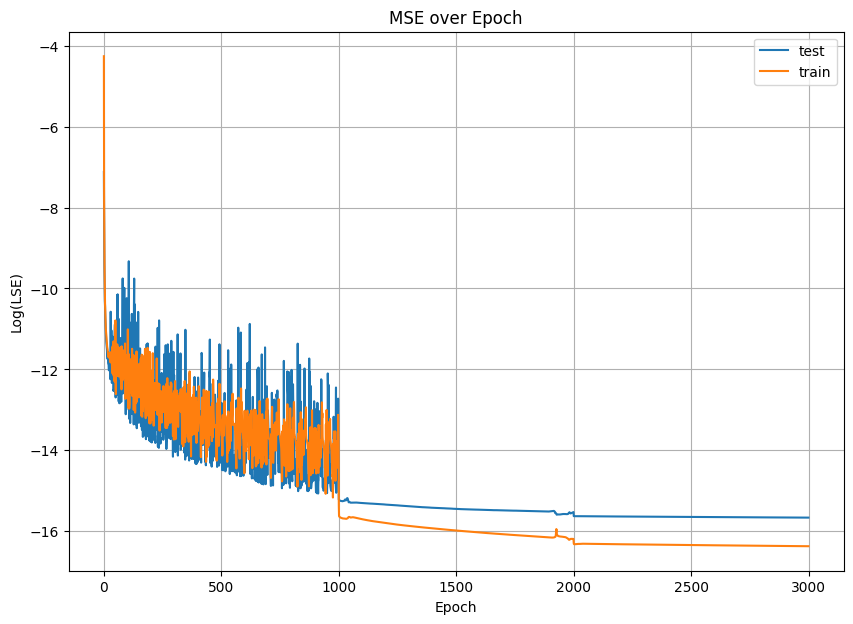

In [48]:
# Plotting log(MSE) as a function of epochs
plt.figure(figsize=(10,7))
plt.plot( np.log(test_losses), label = "test")
plt.plot( np.log(train_losses), label = "train")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Log(LSE)")
plt.title("MSE over Epoch" )
plt.grid()
print("Training WIDE {} VS in the article 8.04e-09".format(train_losses[-1]) )

In [49]:
# Loading model
device = 'cuda'
loaded_Heston_ANN = Heston_ANN().to(device)
PATH = "ANN_weights/Heston_ANN.pt"
loaded_Heston_ANN.load_state_dict(torch.load(PATH))
loaded_Heston_ANN.eval()


Heston_ANN(
  (fc1): Linear(in_features=8, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=400, bias=True)
  (fc5): Linear(in_features=400, out_features=1, bias=True)
)

In [50]:
# Loading Train / Test Data
hs_dataset = Heston_LHS_data_generator(n = 10**5)
train_size, test_size = int(hs_dataset.shape[0]*0.9), int(hs_dataset.shape[0]*0.1 ) # 10% SPLIT
train_dataset, test_dataset = torch.utils.data.random_split(hs_dataset, [train_size, hs_dataset.shape[0]-train_size])
args =  {"batch_size": 1024,
         "test_batch_size": 4048,
         "epochs" : 3*10**3,
         "lr": 1e-4,
         "gamma": .1,
         "no_cuda" : False,
         "run_dry": False,
         "seed": 0,
         "log_interval" : 100,
         "dry_run" : False,
         "save_model": True}
train_loader = torch.utils.data.DataLoader(train_dataset,args["batch_size"])
test_loader = torch.utils.data.DataLoader(test_dataset, args["test_batch_size"])

------ INPUT ------
S/K.......... [0.61 1.39]
Tau.......... [0.11 1.39]
r............ [0.01 0.09]
Corr ........ [-0.94 -0.01]
Kappa........ [0.41 1.99]
V_bar........ [0.01 0.49]
Gamma........ [0.01 0.49]
V_0 ......... [0.06 0.49]
------ OUTPUT ------
V/K.......... [0.00 0.64]


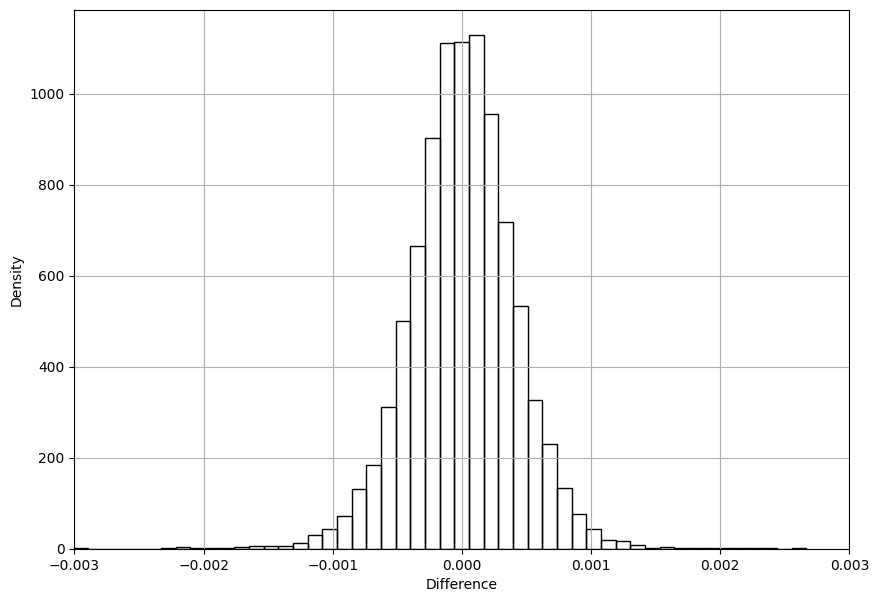

MAX  0.00266546
MIN  -0.0030121505


In [51]:
# Plotting erros histogram
errors = []
with torch.no_grad():
  for data in test_loader:
    data, target = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_Heston_ANN(data)
    errors.append((target-output).data.cpu().numpy())
  errors = np.concatenate(errors)
plt.figure(figsize=(10,7))
plt.hist(errors,50,fill=False)
plt.grid()
plt.xlabel("Difference")
plt.ylabel("Density")
plt.xlim([-0.003, 0.003])
plt.show()
print("MAX ",errors.max())
print("MIN ",errors.min())


In [52]:
# printing train and test erros MSE, MAE, MAPE, R2.
outputs = []
targets = []
with torch.no_grad():
  for data in train_loader:
    data, target = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_Heston_ANN(data)
    outputs.append((output).data.cpu().numpy())
    targets.append((target).data.cpu().numpy())
  outputs = np.concatenate(outputs)
  targets = np.concatenate(targets)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
print("-----------Train scores----------------")
print("MSE {:e}".format(mean_squared_error(outputs,targets)) )
print("MAE {:e}".format(mean_absolute_error(outputs,targets)) )
print("MAPE {:e}".format(mean_absolute_percentage_error(outputs,targets)) )
print("R2 {:e}".format(r2_score(outputs,targets)) )


outputs = []
targets = []
with torch.no_grad():
  for data in test_loader:
    data, target = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_Heston_ANN(data)
    outputs.append((output).data.cpu().numpy())
    targets.append((target).data.cpu().numpy())
  outputs = np.concatenate(outputs)
  targets = np.concatenate(targets)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
print("-----------Test scores----------------")
print("MSE {:e}".format(mean_squared_error(outputs,targets)) )
print("MAE {:e}".format(mean_absolute_error(outputs,targets)) )
print("MAPE {:e}".format(mean_absolute_percentage_error(outputs,targets)) )
print("R2 {:e}".format(r2_score(outputs,targets)) )

-----------Train scores----------------
MSE 1.620948e-07
MAE 3.069885e-04
MAPE 1.953139e-02
R2 9.999926e-01
-----------Test scores----------------
MSE 1.664916e-07
MAE 3.105019e-04
MAPE 1.748970e-02
R2 9.999923e-01


In [53]:
np.sqrt(1.670718e-07)

0.0004087441742704108

# 5) BRENT

In [54]:
from scipy import optimize

def calcimpliedvol(dataset):
    """
    Computes the implied volatilities using the brent method.
    dataset: numpy array containing moneyness, time to maturity, risk free interest rate and V/K.
    Returns a vector of implied volatilities.
    """
    money = np.array(dataset[0])
    T = np.array(dataset[1])
    r = np.array(dataset[2])
    marketoptionPrice = np.array(dataset[3])
    def bs_price(sigma):
      d1 = ( np.log(money) + (r + 0.5 * sigma ** 2) * (T) ) / (sigma * np.sqrt(T))
      d2 = d1 - sigma*np.sqrt(T)
      value_moyeness = money * norm.cdf(d1) - np.exp(-r * (T)) * norm.cdf(d2) 
      fx = value_moyeness - marketoptionPrice
      return fx
    return optimize.brentq(bs_price,-1,1,maxiter=100)

bs_dataset = bs_LHS_data_generator(n=10**4).data
ground_truth_vol = bs_dataset[:,3]
bs_dataset = bs_dataset[:,np.array([0,1,2,4])]
vol_imp = np.apply_along_axis(calcimpliedvol, 1, bs_dataset)
print("MSE ", ((ground_truth_vol - vol_imp)**2).mean().item())

------ INPUT ------
S/K.......... [0.40 1.60]
Tau.......... [0.20 1.10]
r............ [0.02 0.10]
Sigma........ [0.01 1.00]
------ OUTPUT ------
V/K.......... [0.00 0.85]
MSE  0.00014862391368948422


# 6) Pipeline 1: COS + BRENT

In [55]:
eps = 1e-2 # is used to generate open intervals
# (S/K), (tau), (r), (rho), (kappa), (vbar), (gamma), (v0).
# CASE 1 in table 11
l_bounds = [.75+eps, .4+eps, .0+eps, -0.95+eps, .4+eps, .0+eps, .0+eps, .05+eps]
u_bounds = [1.25-eps, 1.-eps, .1-eps, 0.0-eps, 2.0-eps, .5-eps, .5-eps, .5-eps]
hs_dataset = Heston_LHS_data_generator(10**5, l_bounds = l_bounds, u_bounds=u_bounds)
hs_dataset_data = hs_dataset.data
hs_dataset_data = hs_dataset_data[:,np.array([0,1,2,8])]
implied_vol_pipe1 = np.apply_along_axis(calcimpliedvol, 1, hs_dataset_data)

------ INPUT ------
S/K.......... [0.76 1.24]
Tau.......... [0.41 0.99]
r............ [0.01 0.09]
Corr ........ [-0.94 -0.01]
Kappa........ [0.41 1.99]
V_bar........ [0.01 0.49]
Gamma........ [0.01 0.49]
V_0 ......... [0.06 0.49]
------ OUTPUT ------
V/K.......... [0.00 0.47]


# 7) Pipeline 2: Heston-ANN + IV-ANN

In [56]:
# Loading model
device = torch.device("cuda")
loaded_Heston_ANN = Heston_ANN().to(device)
PATH = "ANN_weights/Heston_ANN.pt"
loaded_Heston_ANN.load_state_dict(torch.load(PATH))
loaded_Heston_ANN.eval()

# data loader 
loader = torch.utils.data.DataLoader(hs_dataset, 4048)
# Computing prices
prices = []
with torch.no_grad():
  for data in loader:
    data, _ = data[:,:-1].to(device), data[:,-1].to(device)
    output = loaded_Heston_ANN(data)
    prices.append((output).data.cpu().numpy())
  prices = np.concatenate(prices)

# Loading model 
device = torch.device("cuda")
loaded_IV_ANN = IV_ANN().to(device)
PATH = "ANN_weights/IV_SCALED_ANN.pt"
loaded_IV_ANN.load_state_dict(torch.load(PATH))
loaded_IV_ANN.eval()


# Plugging in the Heston-ANN prices
hs_dataset2 = hs_dataset.data[:,np.array([0,1,2,8])]
hs_dataset2.data[:,3] = torch.FloatTensor(prices)
loader2 = torch.utils.data.DataLoader(hs_dataset2, 4048)

# Computing IVs
implied_vol = []
indecies_list = []
with torch.no_grad():
  for idx, data in enumerate(loader2):
    data = data.to(device)
    # LOG Transformation
    data[:,3] = data[:,3] - torch.maximum(data[:,0]-torch.exp(-data[:,1]*data[:,2]),torch.zeros(data[:,0].shape).to(device))
    data[:,3] = torch.log(data[:,3])
    output = loaded_IV_ANN(data)
    implied_vol.append((output).data.cpu().numpy())
  implied_vol_pipe2 = np.concatenate(implied_vol)
  # indecies_list = np.concatenate(indecies_list).flatten()


In [57]:
# Eliminating Nan values resulting from prices lower than 1e-7
indecies = np.argwhere(np.isnan(implied_vol_pipe2))
implied_vol_pipe1 = np.delete(implied_vol_pipe1, indecies,0)
implied_vol_pipe2 = np.delete(implied_vol_pipe2, indecies,0)

# 8) Pipeline 1 VS pipeline 2

In [58]:
# CASE 1
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
outputs = implied_vol_pipe2
targets = implied_vol_pipe1
print("-----------Vol scores----------------")
print("MSE {:e}".format(mean_squared_error(outputs,targets)) )
print("RMSE {:e}".format(np.sqrt(mean_squared_error(outputs,targets))) )
print("MAE {:e}".format(mean_absolute_error(outputs,targets)) )
print("MAPE {:e}".format(mean_absolute_percentage_error(outputs,targets)) )
print("R2 {:e}".format(r2_score(outputs,targets)) )

-----------Vol scores----------------
MSE 2.076680e-06
RMSE 1.441069e-03
MAE 1.114881e-03
MAPE 2.357523e-03
R2 9.997799e-01


In [74]:
# CASE 2
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
outputs = implied_vol_pipe2
targets = implied_vol_pipe1
print("-----------Vol scores----------------")
print("MSE {:e}".format(mean_squared_error(outputs,targets)) )
print("RMSE {:e}".format(np.sqrt(mean_squared_error(outputs,targets))) )
print("MAE {:e}".format(mean_absolute_error(outputs,targets)) )
print("MAPE {:e}".format(mean_absolute_percentage_error(outputs,targets)) )
print("R2 {:e}".format(r2_score(outputs,targets)) )

-----------Vol scores----------------
MSE 4.065135e-07
RMSE 6.375841e-04
MAE 4.932424e-04
MAPE 1.574925e-03
R2 8.757847e-01


# 9) Volatility surface (COS + IV-ANN)

### Initial volatility surface

In [60]:
# Generating the surface points
r= .02
tau= 0.5
rho = -0.05
kappa= 1.5
vbar = .1
gamma = .3
v0 = 0.1
moyeness = 0.74
moyeness = np.linspace(moyeness, 1.24,11)
tau = np.linspace(tau, 1, 6)

cos_prices = []
X = []
Y = []
for m in moyeness:
  for t in tau:
    X.append(m)
    Y.append(t)
    cos_prices.append(call_option_Heston_moy(N = 160, L= 12, r= r, tau= t, kappa= kappa, gamma = gamma, vbar = vbar, v0 = v0, rho = rho, moyeness = m))

In [61]:
# Reshaping for torch tensor dataset
cos_prices = np.array(cos_prices).reshape((-1, 1))
X = np.array(X).reshape((-1, 1))
Y = np.array(Y).reshape((-1, 1))
r = np.array(r*np.ones(66)).reshape((-1, 1))

In [62]:
# Creating a torch dataset
data = np.concatenate((X, Y, r, cos_prices), axis = 1)
data = torch.FloatTensor(data)

In [63]:
# Getting the implied volatility from the dataset
with torch.no_grad():
  data = data.to(device)
  data[:,3] = data[:,3] - torch.maximum(data[:,0]-torch.exp(-data[:,1]*data[:,2]),torch.zeros(data[:,0].shape).to(device))
  data[:,3] = torch.log(data[:,3])
  output = loaded_IV_ANN(data)
  bs_IV = (output).data.cpu().numpy()

X = X.flatten()
Y = Y.flatten()
Z = bs_IV

x = np.reshape(X, (-1, 6))
y = np.reshape(Y, (-1, 6))
z = np.reshape(Z, (-1, 6))

In [64]:
from mpl_toolkits import mplot3d
from matplotlib import cm

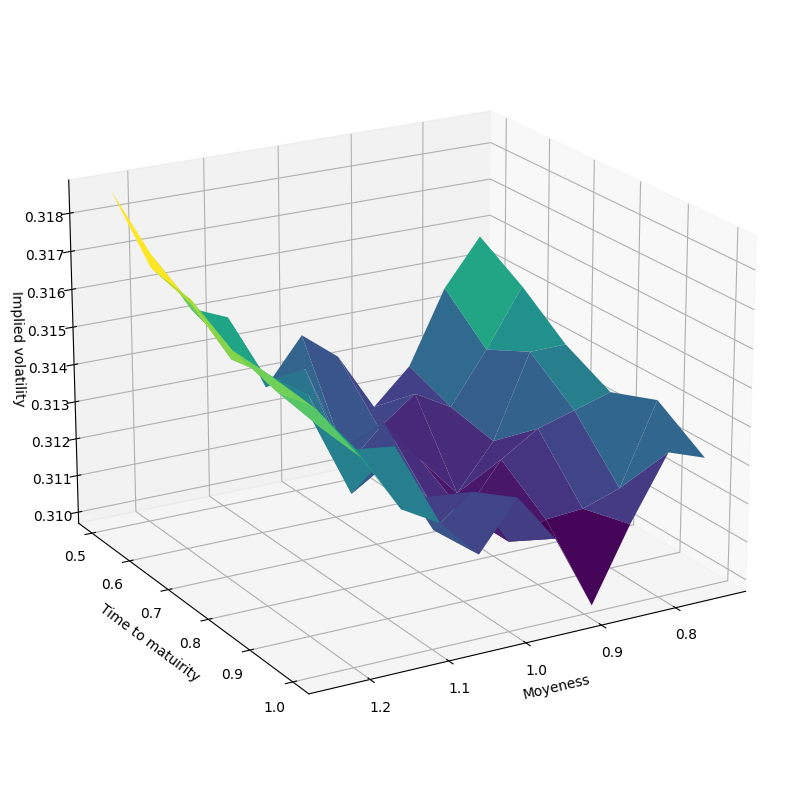

In [65]:
# Plotting the initial volatility surface
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.view_init(elev=20, azim=60)
ax.plot_surface(x, y, z,cmap='viridis', edgecolor='none', antialiased=True)
ax.set_xlabel('Moyeness')
ax.set_ylabel('Time to matuirity')
ax.set_zlabel('Implied volatility')
plt.show()

### Smoothing the volatility surface

In [66]:
from scipy import interpolate

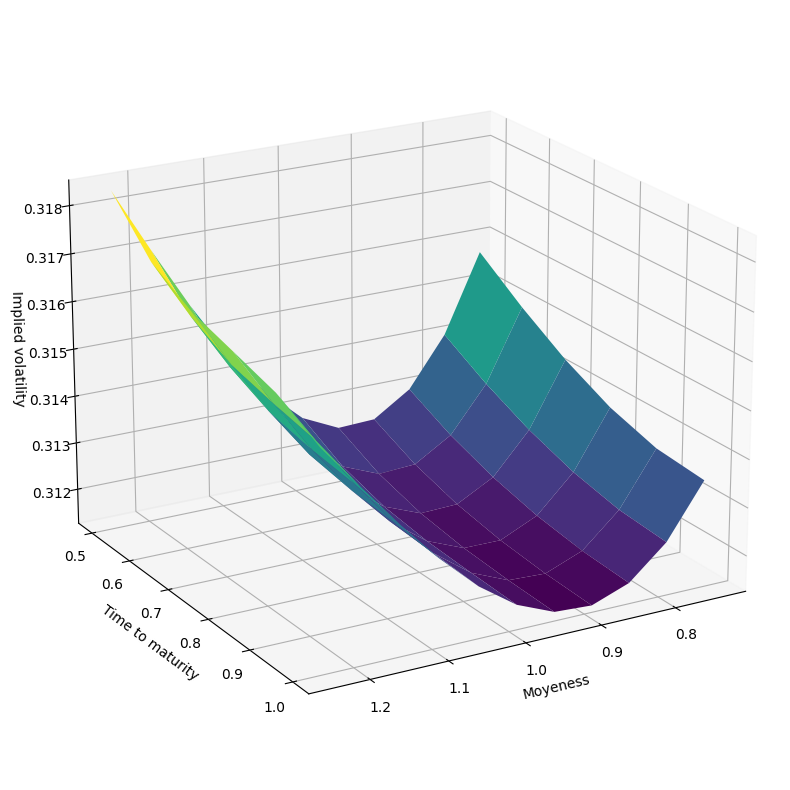

In [67]:
# Smoothing the volatility surface
xnew, ynew = x.copy(), y.copy()
tck = interpolate.bisplrep(x, y, z, s=1.0)
znew = interpolate.bisplev(xnew[:,0], ynew[0,:], tck)

plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.view_init(elev=20, azim=60)
ax.plot_surface(xnew, ynew, znew,cmap='viridis', edgecolor='none', antialiased=True)
ax.set_xlabel('Moyeness')
ax.set_ylabel('Time to maturity')
ax.set_zlabel('Implied volatility')
plt.show()

### Implied volatility difference

In [68]:
# Generating the surface points
r= .02
tau= 0.5
rho = -0.05
kappa= 1.5
vbar = .1
gamma = .3
v0 = 0.1
moyeness = 0.74
n_moneyness = 11
n_tau = 6
moyeness = np.linspace(moyeness, 1.24,n_moneyness)
tau = np.linspace(tau, 1, n_tau)

cos_prices = []
X = []
Y = []
for m in moyeness:
  for t in tau:
    X.append(m)
    Y.append(t)
    cos_prices.append(call_option_Heston_moy(N = 160, L= 12, r= r, tau= t, kappa= kappa, gamma = gamma, vbar = vbar, v0 = v0, rho = rho, moyeness = m))

In [69]:
rho = np.array(rho*np.ones(n_tau * n_moneyness)).reshape((-1, 1))
kappa = np.array(kappa*np.ones(n_tau * n_moneyness)).reshape((-1, 1))
vbar = np.array(vbar*np.ones(n_tau * n_moneyness)).reshape((-1, 1))
gamma = np.array(gamma*np.ones(n_tau * n_moneyness)).reshape((-1, 1))
v0 = np.array(v0*np.ones(n_tau * n_moneyness)).reshape((-1, 1))
# Reshaping for torch tensor dataset
cos_prices = np.array(cos_prices).reshape((-1, 1))
X = np.array(X).reshape((-1, 1))
Y = np.array(Y).reshape((-1, 1))
r = np.array(r*np.ones(n_tau * n_moneyness)).reshape((-1, 1))

In [70]:
data_ann = np.concatenate((X, Y, r, rho, kappa, vbar, gamma, v0, cos_prices), axis = 1)
data_ann = torch.FloatTensor(data_ann)
# Creating a torch dataset
data = np.concatenate((X, Y, r, cos_prices), axis = 1)
data = torch.FloatTensor(data)

In [71]:
implied_vol_pipe1 = np.apply_along_axis(calcimpliedvol, 1, data)

In [72]:
# Getting the implied volatility from the dataset
with torch.no_grad():
  data = data.to(device)
  data[:,3] = data[:,3] - torch.maximum(data[:,0]-torch.exp(-data[:,1]*data[:,2]),torch.zeros(data[:,0].shape).to(device))
  data[:,3] = torch.log(data[:,3])
  output = loaded_IV_ANN(data)
  implied_vol_pipe2 = (output).data.cpu().numpy()



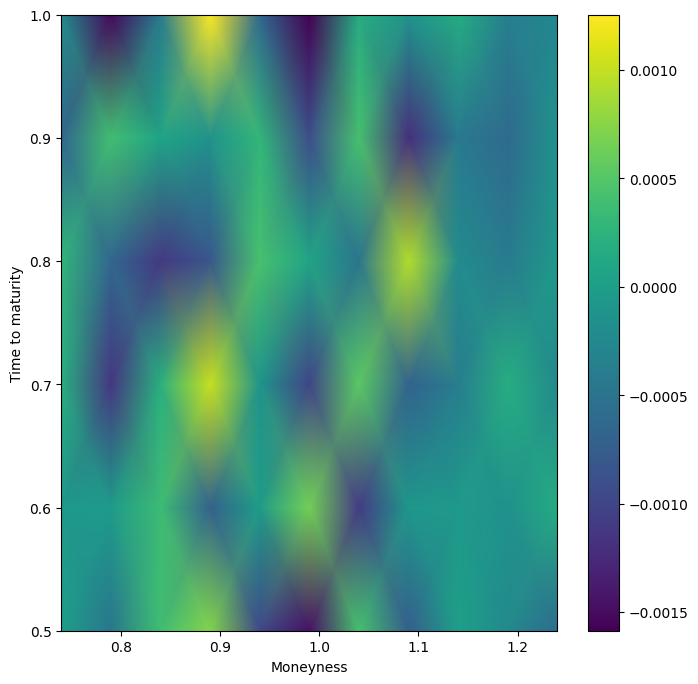

In [73]:
X = X.flatten()
Y = Y.flatten()
Z = (implied_vol_pipe1 - implied_vol_pipe2).flatten()

x = np.reshape(X, (-1, min(n_moneyness, n_tau)))
y = np.reshape(Y, (-1, min(n_moneyness, n_tau)))
z = np.reshape(Z, (-1, min(n_moneyness, n_tau)))

plt.figure(figsize=(8,8))
plt.pcolormesh(x, y, z, shading='gouraud')
plt.colorbar()
plt.xlabel("Moneyness")
plt.ylabel("Time to maturity")
plt.show()